### Working with Financial Data

Publicly traded companies are classified into one of 11 industry sectors, called GICS (Global Industry Classification Standard). Investors use these classes to design and construct portfolios, compare companies, evaluate industries, and isolate regional from global trends.

There are 11 GICS sectors

* Communication services
* Consumer discretionary
* Consumer staples
* Energy
* Financials
* Health care
* Industrials
* Information technology
* Materials
* Real estate
* Utilities


In this notebook we'll work with financial data, grouped by sector, to analyze different trends in companies and sectors listed on the S&P 500. 


Begin by loading the GICS sector mappings. They've been provided to you in a file called `gics.csv`


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:
gics = pd.read_csv("gics.csv");
#gics.set_index("Code", drop=True, inplace=True)
print(gics)

    Code                    Name
0     50  Communication services
1     25  Consumer discretionary
2     30        Consumer staples
3     10                  Energy
4     40              Financials
5     35             Health care
6     20             Industrials
7     45  Information technology
8     15               Materials
9     60             Real estate
10    55               Utilities


Load the S&P 500 sector mappings and take a look at the data. The file is called `sp500-sector.csv`

In [113]:
sp500 = pd.read_csv("sp500-sector.csv")
#sp500.set_index("Symbol", drop=True, inplace=True)
print(sp500.head())

  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology


Create a dataframe that has the S&P 500 stock symbols with the appropriate sector number. For example, `3M`, symbol `MMM` is in `industrials` which corresponds to sector 20.

In [20]:
sp500_with_gics = sp500.merge(gics, how="left", left_on="Sector", right_on="Name", suffixes=("","_gics"))
print(sp500_with_gics.head())

  Symbol                 Name                  Sector  Code    Name_gics
0    MMM           3M Company             Industrials  20.0  Industrials
1    AOS      A.O. Smith Corp             Industrials  20.0  Industrials
2    ABT  Abbott Laboratories             Health Care   NaN          NaN
3   ABBV          AbbVie Inc.             Health Care   NaN          NaN
4    ACN        Accenture plc  Information Technology   NaN          NaN


Load the file `sp500-5yr.csv` into a dataframe. This file contains 5 years worth of historical prices for securities listed on the S&P 500.

In [31]:
sp5yr = pd.read_csv("sp500-5yr.csv")
print(sp5yr.head())
print(sp5yr["date"].min())
print(sp5yr["date"].max())

         date   open   high    low  close    volume symbol
0  2013-02-08  15.07  15.12  14.63  14.75   8407500    AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000    AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000    AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500    AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900    AAL
2013-02-08
2018-02-07


Determine which sectors had the best performance for the past year, past three years and past five years. Note the start and end dates on the dataset.

In [71]:
ds = sp500_with_gics.merge(sp5yr, how="left", left_on="Symbol", right_on="symbol")
ds = ds[["Symbol", "Sector", "date", "close"]]
date_5yr="2013-02-08"
date_3yr="2015-02-09" # Market not open on 8th.
date_1yr="2017-02-08"
date_now="2018-02-07"

ds_perf = ds.loc[(ds.date == date_5yr) | (ds.date == date_3yr) | (ds.date == date_1yr) | (ds.date == date_now)]
ds_perf.set_index(["Sector", "Symbol", "date"], inplace=True)
ds_perf = ds_perf.unstack()
ds_perf.columns = ds_perf.columns.droplevel()
ds_perf["5year"] = ds_perf[date_now] - ds_perf[date_5yr]
ds_perf["3year"] = ds_perf[date_now] - ds_perf[date_3yr]
ds_perf["1year"] = ds_perf[date_now] - ds_perf[date_1yr]
ds_perf = ds_perf.drop([date_now, date_5yr, date_3yr, date_1yr], axis=1)
print(ds_perf.head())

date                             5year    3year   1year
Sector                 Symbol                          
Consumer Discretionary AAP       31.03   -50.81  -52.80
                       AMZN    1154.83  1046.22  597.07
                       APTV        NaN      NaN     NaN
                       AZO      342.44   115.28  -12.73
                       BBY       55.97    34.19   27.39


                                5year      3year      1year
Sector                                                     
Consumer Discretionary      3904.9153  1777.5648  1156.1511
Consumer Staples            1049.4617   425.3334   111.6500
Energy                       -22.2150  -169.4950   -49.9000
Financials                  3010.2583  1762.1390  1111.2750
Health Care                 4491.6885  1959.9485  1528.6319
Industrials                 4052.3332  2376.4673  1468.7200
Information Technology      4305.4958  3532.4651  1970.5800
Materials                   1033.9480   593.8830   370.2500
Real Estate                  699.4000    99.6100   -96.7000
Telecommunication Services   -15.9800   -18.4000    -9.0100
Utilities                    383.2800    56.1000   -46.0400


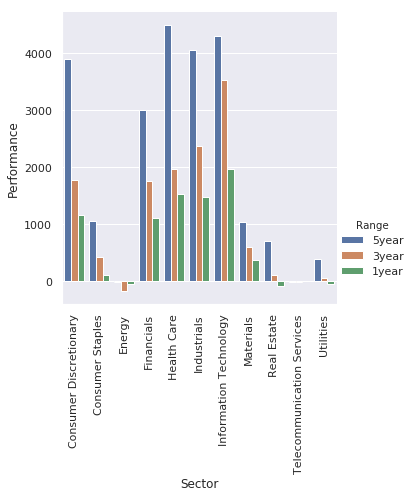

In [87]:
perf = ds_perf.groupby("Sector").agg({
    "5year": "sum",
    "3year": "sum",
    "1year": "sum"
})
print(perf)

perf = perf.reset_index()
perf = pd.melt(perf, id_vars="Sector", var_name="Range", value_name="Performance")
g=sns.catplot(x="Sector", y="Performance", hue="Range", data=perf, kind="bar")
plt.xticks(rotation=90)
plt.show()

For each sector, determine the top performer and the bottom performer for the 1 year, 3 year, and 5 year windows.

In [126]:
perf.reset_index()
perf5 = ds_perf.loc[ds_perf.groupby(["Sector"], sort=False)['5year'].idxmax()].reset_index()
perf5 = perf5[["Sector", "Symbol"]]
perf5["Year"] = 5
perf3 = ds_perf.loc[ds_perf.groupby(["Sector"], sort=False)['3year'].idxmax()].reset_index()
perf3 = perf3[["Sector", "Symbol"]]
perf3["Year"] = 3
perf1 = ds_perf.loc[ds_perf.groupby(["Sector"], sort=False)['1year'].idxmax()].reset_index()
perf1 = perf1[["Sector", "Symbol"]]
perf1["Year"] = 1
perf_best = pd.concat([perf1, perf3, perf5])

perf_best = perf_best.merge(sp500, how="left", left_on="Symbol", right_on="Symbol", suffixes=("","_"))
perf_best = perf_best[["Sector", "Name", "Year"]]
perf_best = perf_best.pivot(index="Sector", columns="Year", values="Name")
print(perf_best)

Year                                             1                     3  \
Sector                                                                     
Consumer Discretionary             Amazon.com Inc.       Amazon.com Inc.   
Consumer Staples              Constellation Brands  Constellation Brands   
Energy                               Valero Energy      Concho Resources   
Financials                               BlackRock             BlackRock   
Health Care                         Mettler Toledo        Mettler Toledo   
Industrials                         Boeing Company        Boeing Company   
Information Technology        Alphabet Inc Class C  Alphabet Inc Class A   
Materials                         Sherwin-Williams      Sherwin-Williams   
Real Estate                     SBA Communications               Equinix   
Telecommunication Services  Verizon Communications             AT&T Inc.   
Utilities                           NextEra Energy        NextEra Energy   

Year       

In [127]:
perf.reset_index()
perf5 = ds_perf.loc[ds_perf.groupby(["Sector"], sort=False)['5year'].idxmin()].reset_index()
perf5 = perf5[["Sector", "Symbol"]]
perf5["Year"] = 5
perf3 = ds_perf.loc[ds_perf.groupby(["Sector"], sort=False)['3year'].idxmin()].reset_index()
perf3 = perf3[["Sector", "Symbol"]]
perf3["Year"] = 3
perf1 = ds_perf.loc[ds_perf.groupby(["Sector"], sort=False)['1year'].idxmin()].reset_index()
perf1 = perf1[["Sector", "Symbol"]]
perf1["Year"] = 1
perf_worst = pd.concat([perf1, perf3, perf5])

perf_worst = perf_worst.merge(sp500, how="left", left_on="Symbol", right_on="Symbol", suffixes=("","_"))
perf_worst = perf_worst[["Sector", "Name", "Year"]]
perf_worst = perf_worst.pivot(index="Sector", columns="Year", values="Name")
print(perf_worst)

Year                                                      1  \
Sector                                                        
Consumer Discretionary               Chipotle Mexican Grill   
Consumer Staples               Molson Coors Brewing Company   
Energy                                       Cimarex Energy   
Financials                                     MetLife Inc.   
Health Care                                   Allergan, Plc   
Industrials                               Acuity Brands Inc   
Information Technology      International Business Machines   
Materials                         Martin Marietta Materials   
Real Estate                            Vornado Realty Trust   
Telecommunication Services                  CenturyLink Inc   
Utilities                                        SCANA Corp   

Year                                                    3  \
Sector                                                      
Consumer Discretionary             Chipotle Mexican Grill 